In [47]:
# Append the path to the src folder to the system path
# To be able to import the modules in the src folder
import sys
sys.path.append('..\\src\\')

# Environment Variables

environ = 'local'

# This will later be in Google Cloud Storage
#environ = 'gcp'
PROJECT_ID = 'csi5150_project'
CSC_BUCKET = f'{PROJECT_ID}_csc_data_bucket'

DATASETS_PATH = '..\\local_storage\\csc_data'

if environ == 'gcp':
    DATASETS_PATH = f'gs://{CSC_BUCKET}'


Feature Engineering

In [48]:
from scipy.signal import savgol_filter

import numpy as np


def savitzky_golay_filter(data, window_size=5, polynomial_order=3):
    """Applies a Savitzky-Golay filter to the data."""
    return savgol_filter(data, window_size, polynomial_order)

def differentiate(data, time):
    """Differentiates data with respect to time."""
    return np.gradient(data, time)

def add_steering_velocity(df):
    """Adds a new feature to the dataframe: steering velocity."""
    
    df = df.copy()
    
   #  assert (df['t'].diff() > 0).all(), "Timestamps are not strictly increasing!"

    # df.loc[:, 'steeringVelocity'] = differentiate(df['steeringAngleDeg'], df['t'])
    df['steeringVelocity'] = df['steeringAngleDeg'].diff() / (df['t'].diff() + 1e-8)

    # TODO: Add/explore preprocessing for steering velocity
    # Replace inf/-inf with the maximum/minimum finite values
    # df.replace([np.inf, -np.inf], np.nan, inplace=True)
    max_finite = df['steeringVelocity'][np.isfinite(df['steeringVelocity'])].max()
    min_finite = df['steeringVelocity'][np.isfinite(df['steeringVelocity'])].min()
    df['steeringVelocity'] = np.clip(df['steeringVelocity'], min_finite, max_finite)

    # df['steeringVelocity'] = df['steeringVelocity'].rolling(window=5, min_periods=1).mean()
    df.fillna(0, inplace=True)

    # Apply filter to remove noise
    df['steeringVelocity'] = savitzky_golay_filter(df['steeringVelocity'], 5, 2)
    # df['steeringVelocity'] = moving_average(df['steeringVelocity'], 1)

    return df

def add_steering_acceleration(df):
    """Adds a new feature to the dataframe: steering acceleration."""

    df = df.copy()

    # assert (df['t'].diff() > 0).all(), "Timestamps are not strictly increasing!"

    # df.loc[:, 'steeringAcceleration'] = differentiate(df['steeringVelocity'], df['t'])
    df['steeringAcceleration'] = df['steeringVelocity'].diff() / (df['t'].diff() + 1e-8)

    # df.replace([np.inf, -np.inf], np.nan, inplace=True)
    max_finite = df['steeringAcceleration'][np.isfinite(df['steeringAcceleration'])].max()
    min_finite = df['steeringVelocity'][np.isfinite(df['steeringAcceleration'])].min()
    df['steeringAcceleration'] = np.clip(df['steeringAcceleration'], min_finite, max_finite)

    # df['steeringAcceleration'] = df['steeringAcceleration'].rolling(window=5, min_periods=1).mean()
    df.fillna(0, inplace=True)

    # Apply filter to remove noise
    df['steeringAcceleration'] = savitzky_golay_filter(df['steeringAcceleration'], 5, 2)
    # df['steeringVelocity'] = moving_average(df['steeringVelocity'], 1)

    return df

def add_rolling_torque(df):
    """Adds a new feature to the dataframe: rolling torque."""
    
    df = df.copy()

    df["torqueRollingMean"] = df["steerFiltered"].rolling(window=4, min_periods=1).mean()

    return df



In [49]:
import logging

from data.csc_data import CSCDataset
from data.df_preprocessing import (
  MinMaxScalerDP, CompositeDP, TorqueLagAdderDP, 
  LowPassFilterDP, FeatureAdderDP, FeatureRemoverDP
)
from functions.constants import FEATURES

DATASET_NAME = 'AUDI_Q3_2ND_GEN'
IS_PREDICTION = False


# TODO: These will be part of the training data pipeline in the actual code (not a notebook)
# When deploying the model, we will have access to velocity and acceleration (in CARLA)

# Not using MinMaxScalerDP for now (XGBoost is not sensitive to feature scaling)
train_preprocessor = CompositeDP([
    FeatureAdderDP([
        add_steering_velocity,
        add_steering_acceleration,
        add_rolling_torque
    ]),
    TorqueLagAdderDP(lag=1),
    TorqueLagAdderDP(lag=2),
    TorqueLagAdderDP(lag=3),
    FeatureRemoverDP(['t']),
    FeatureRemoverDP(['steerFiltered'])
])

label_preprocessor = None


dataset = CSCDataset(DATASET_NAME, 
                     FEATURES,
                     download=False,
                     train_preprocessor=train_preprocessor,
                     label_preprocessor=label_preprocessor,
                     is_prediction=IS_PREDICTION,
                     logging_level=logging.INFO)
total_dataset_size, num_csv = dataset.get_csv_metadata()

print(f"Total file size of dataset: {round(total_dataset_size, 3)} MB")
print(f"Number of CSV files in dataset: {num_csv}")

print(f"Number of samples in dataset: {len(dataset)}")



Total file size of dataset: 149.99 MB
Number of CSV files in dataset: 1000
Number of samples in dataset: 1000


In [50]:
from torch.utils.data import DataLoader

# Load all data at once
train_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

# Extract features and labels
features_list, targets_list = [], []

for batch_idx, (X, y) in enumerate(train_loader):
    # Convert PyTorch tensors to NumPy
    features_list.append(X.numpy())  
    targets_list.append(y.numpy())


# Convert to NumPy arrays
# Shape: (num_samples, num_features)
X_np = np.vstack(features_list)

# Shape: (num_samples,)
y_np = np.hstack(targets_list)   

# Check data shape
print("Features shape:", X_np.shape)
print("Targets shape:", y_np.shape)


Features shape: (1000, 601, 9)
Targets shape: (1000, 601)


XGBoost Model

In [51]:
import xgboost as xgb
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split dataset (80% train, 20% test)
train_size = int(0.8 * len(X_np))
X_train, X_test = X_np[:train_size], X_np[train_size:]
y_train, y_test = y_np[:train_size], y_np[train_size:]


# Need to reshape into a 2D array for XGBoost (num_samples, num_features) - flatten the 3D array

num_features = X_np.shape[2]

# Reshape 3D array into 2D array
X_train = X_train.reshape(-1, num_features)
X_test = X_test.reshape(-1, num_features)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Train XGBoost Model
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=700,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8
)

model.fit(X_train, y_train, 
          eval_set=[(X_test, y_test)],
          verbose=True)




X_train shape: (480800, 9)
X_test shape: (120200, 9)
[0]	validation_0-rmse:0.23059
[1]	validation_0-rmse:0.21980
[2]	validation_0-rmse:0.20957
[3]	validation_0-rmse:0.19968
[4]	validation_0-rmse:0.19032
[5]	validation_0-rmse:0.18141
[6]	validation_0-rmse:0.17297
[7]	validation_0-rmse:0.16497
[8]	validation_0-rmse:0.15738
[9]	validation_0-rmse:0.15021
[10]	validation_0-rmse:0.14339
[11]	validation_0-rmse:0.13694
[12]	validation_0-rmse:0.13082
[13]	validation_0-rmse:0.12503
[14]	validation_0-rmse:0.11956
[15]	validation_0-rmse:0.11436
[16]	validation_0-rmse:0.10946
[17]	validation_0-rmse:0.10484
[18]	validation_0-rmse:0.10045
[19]	validation_0-rmse:0.09631
[20]	validation_0-rmse:0.09240
[21]	validation_0-rmse:0.08872
[22]	validation_0-rmse:0.08523
[23]	validation_0-rmse:0.08195
[24]	validation_0-rmse:0.07886
[25]	validation_0-rmse:0.07597
[26]	validation_0-rmse:0.07349
[27]	validation_0-rmse:0.07091
[28]	validation_0-rmse:0.06850
[29]	validation_0-rmse:0.06622
[30]	validation_0-rmse:0.06

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

(120200,)
(120200,)
Mean Squared Error: 0.0002894350259933137


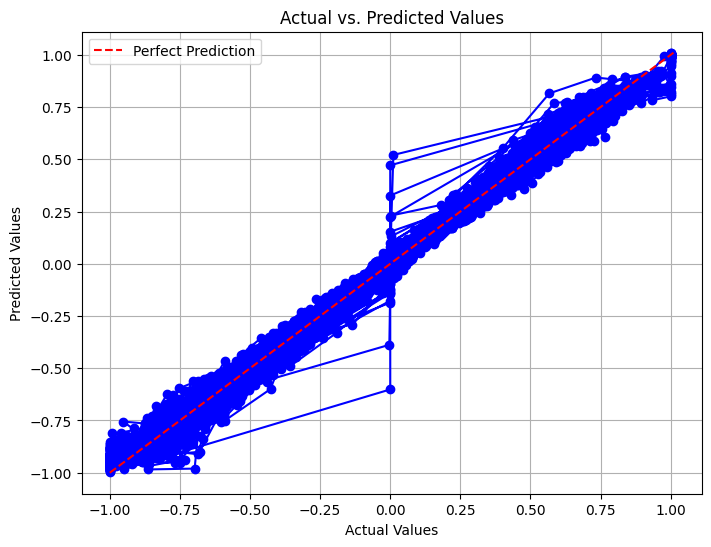

In [52]:
# Reshape 3D array into 2D array (1300)

y_test = y_test.reshape(-1, 1).squeeze()
print(y_test.shape)

# Evaluate Model
y_pred = model.predict(X_test)

print(y_pred.shape)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Plot predictions vs. actual values, in a linear plot
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.plot(y_test, y_pred, marker='o', linestyle='-', color='blue')

# Add a diagonal line for perfect predictions
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='red', label='Perfect Prediction')

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a legend
plt.legend()

plt.grid(True)
plt.show()

In [53]:
print(y_test.min(), y_test.max())

-1.0 1.0


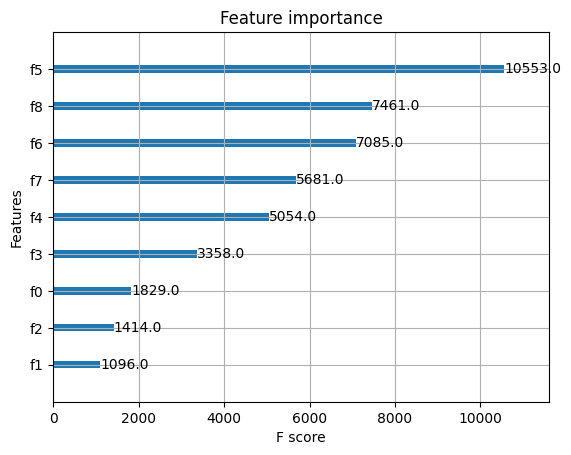

In [54]:
import matplotlib.pyplot as plt

xgb.plot_importance(model)
plt.show()

Skipped 315 files
(1, 601, 9)
(1, 601)
(601, 9)
(601, 1)
(601,)


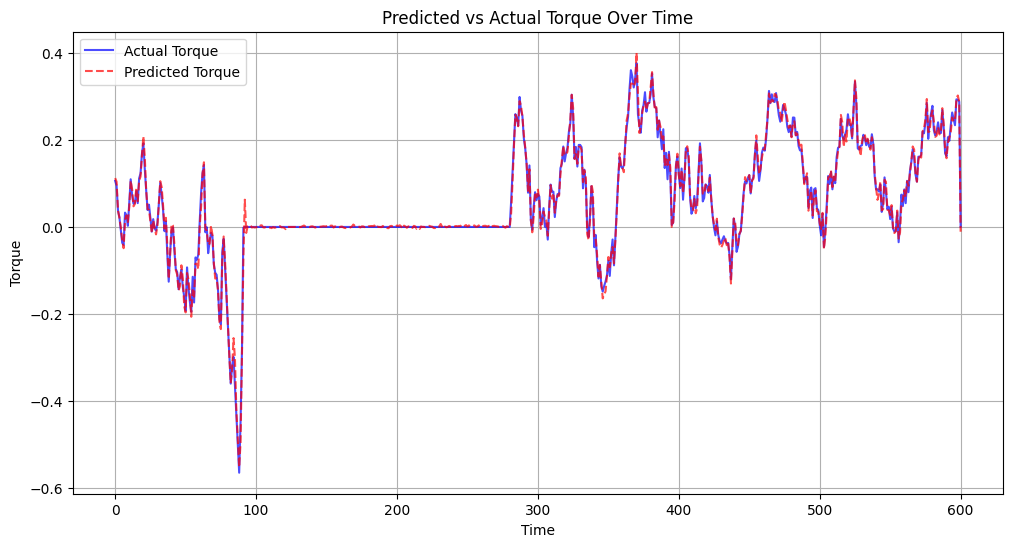

In [60]:
DATASET_NAME = 'TOYOTA_RAV4_2022'
IS_PREDICTION = True


# TODO: These will be part of the training data pipeline in the actual code (not a notebook)
# When deploying the model, we will have access to velocity and acceleration (in CARLA)

# Not using MinMaxScalerDP for now (XGBoost is not sensitive to feature scaling)
train_preprocessor = CompositeDP([
    FeatureAdderDP([
        add_steering_velocity,
        add_steering_acceleration, 
        add_rolling_torque # 5
    ]),
    TorqueLagAdderDP(lag=1),
    TorqueLagAdderDP(lag=2),
    TorqueLagAdderDP(lag=3),
    FeatureRemoverDP(['t']),
    FeatureRemoverDP(['steerFiltered'])
])

label_preprocessor = None


test_dataset = CSCDataset(DATASET_NAME, 
                     FEATURES,
                     download=False,
                     train_preprocessor=train_preprocessor,
                     label_preprocessor=label_preprocessor,
                     is_prediction=IS_PREDICTION,
                     logging_level=logging.INFO)


# Load one csv file at a time
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Extract features and labels
features_list, targets_list = [], []
csv_id = 315
skipped = 0

X = None
y = None


for batch_idx, (X, y) in enumerate(test_loader):

    if not batch_idx == csv_id:
        skipped += 1
        continue

    print(f"Skipped {skipped} files")

    # Convert PyTorch tensors to NumPy
    X = X.numpy()  
    y = y.numpy()
    break


num_features = X.shape[2]



# Plotting

print(X.shape)
print(y.shape)

# Convert to NumPy arrays
# Shape: (num_samples, num_features)
X = X.reshape(-1, num_features)
actual_torque = y.reshape(-1, 1)

print(X.shape)
print(actual_torque.shape)

predicted_torque = model.predict(X)

print(predicted_torque.shape)


# Plot predicted vs actual torque
plt.figure(figsize=(12, 6))
plt.plot(actual_torque, label="Actual Torque", linestyle="-", color="blue", alpha=0.7)
plt.plot(predicted_torque, label="Predicted Torque", linestyle="--", color="red", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Torque")
plt.title("Predicted vs Actual Torque Over Time")
plt.legend()
plt.grid(True)
plt.show()


Hyperparameter Tuning (TODO: Run, it takes a while...)

(1, 611, 7)
(1, 611)
(611, 7)
(611, 1)
(611,)


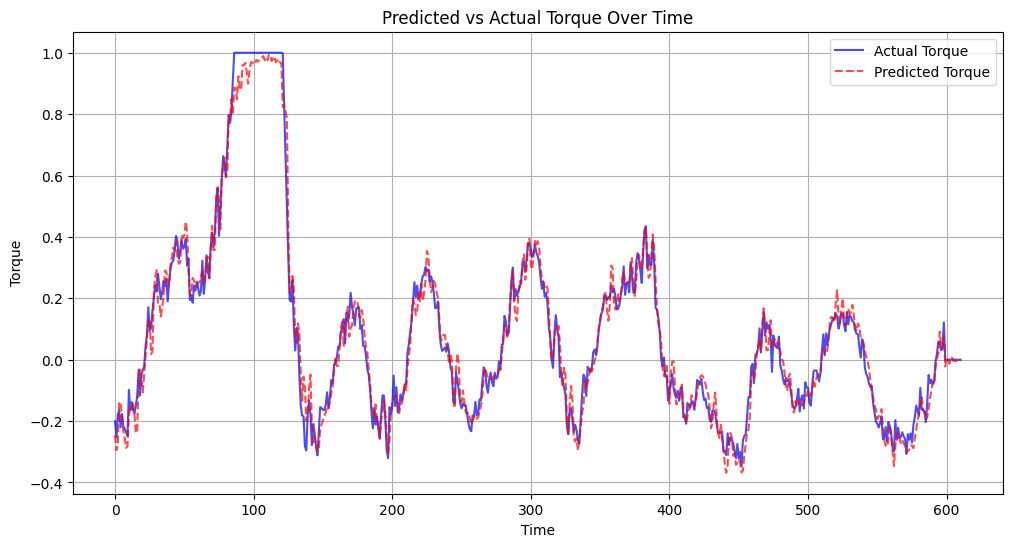

In [ ]:
import optuna

def objective(trial):
    param = {
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
    }

    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)
print(study.best_params)


Previous Predictions (Without torque rolling mean and torque lags):

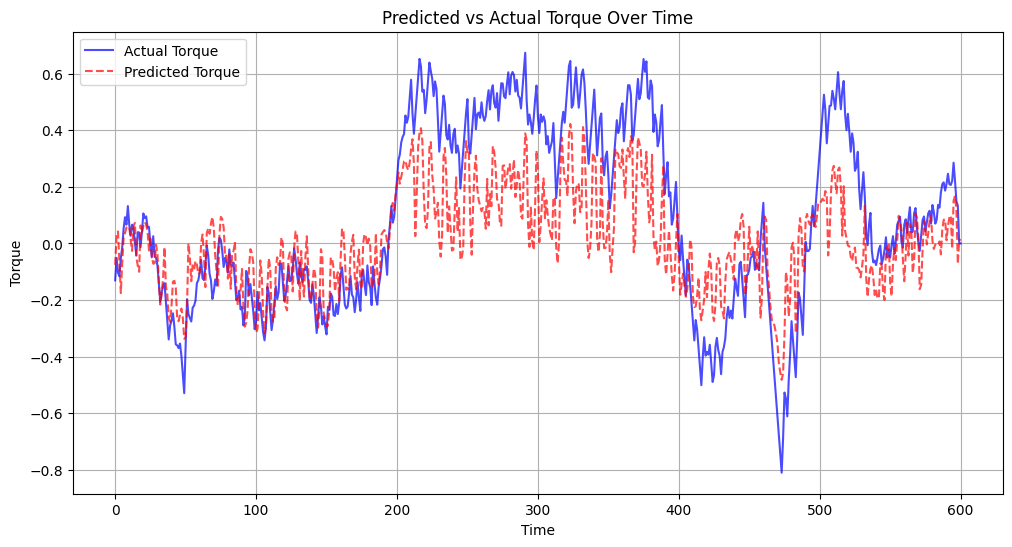